In [257]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from BabyMAKROModel import BabyMAKROModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

In [258]:
model = BabyMAKROModelClass(name='baseline') # create an instance of the model

In [259]:
par = model.par
ss = model.ss
sol = model.sol

# Find steady state

In [260]:
model.find_ss(0.50,do_print=True)

ss.S = 7.44
ss.L = 56.28
ss.delta_L = 0.07
ss.v = 16.52
ss.m_v = 0.23
ss.r_K = 0.14
ss.r_ell = 2.71
ss.ell = 55.87
ss.w = 2.68
ss.G = 100.00
ss.B_G = 50.00
ss.tau = 0.68
solving for household behavior: result.converged = True
ss.C = 49.27
ss.B = 119.18
ss.K = 557.43
ss.I = 55.74
ss.Y = 229.56
ss.X = nan
ss.M = nan
par.phi = 0.988


**Household behavior:**

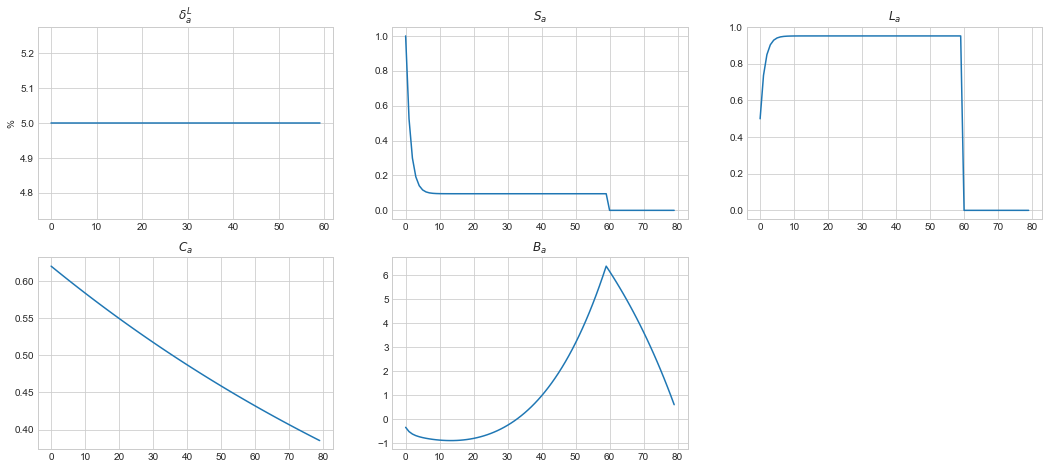

In [261]:
fig = plt.figure(figsize=(3*6,3*6/1.5))

ax = fig.add_subplot(3,3,1)
ax.plot(model.par.delta_L_a*100)
ax.set_ylabel('%')
ax.set_title('$\delta^L_a$')

ax = fig.add_subplot(3,3,2)
ax.plot(model.ss.S_a)
ax.set_title('$S_a$')

ax = fig.add_subplot(3,3,3)
ax.plot(model.ss.L_a)
ax.set_title('$L_a$')

ax = fig.add_subplot(3,3,4)
ax.plot(model.ss.C_a)
ax.set_ylabel('')
ax.set_title('$C_a$')

ax = fig.add_subplot(3,3,5)
ax.plot(model.ss.B_a)
ax.set_ylabel('')
ax.set_title('$B_a$');

# Speed and error tests

In [262]:
model.set_exo_ss()
model.set_unknowns_ss()

**Python evaluation:**

In [263]:
%time model.evaluate_blocks(py=True)

/Users/andreas/MAO/blocks.py:276: RuntimeWarning: divide by zero encountered in true_divide
  term_c = 2*par.beta*(par.iota_0/(par.eta_C-1))*(C_lead/C)*(part_ii-1)*part_ii*P_C_lead
/Users/andreas/MAO/blocks.py:276: RuntimeWarning: invalid value encountered in true_divide
  term_c = 2*par.beta*(par.iota_0/(par.eta_C-1))*(C_lead/C)*(part_ii-1)*part_ii*P_C_lead
/Users/andreas/MAO/blocks.py:276: RuntimeWarning: invalid value encountered in multiply
  term_c = 2*par.beta*(par.iota_0/(par.eta_C-1))*(C_lead/C)*(part_ii-1)*part_ii*P_C_lead


CPU times: user 4.97 s, sys: 99.8 ms, total: 5.07 s
Wall time: 5.53 s


**Check errors:**

In [266]:
errors = model.get_errors(do_print=True)

bargaining_cond     : abs. max = 0.00e+00
Bq_match            : abs. max = 1.30e-13
FOC_capital_agency  : abs. max = 0.00e+00
FOC_K_ell           : abs. max = 7.11e-15
mkt_clearing        : abs. max = 0.00e+00
repacking_prices_C  : abs. max =      nan


**First numba evaluation:**

In [267]:
%time model.evaluate_blocks()

CPU times: user 47.1 s, sys: 1.1 s, total: 48.2 s
Wall time: 52.9 s


**Time:**

In [268]:
%timeit model.evaluate_blocks()
%timeit model.get_errors()

12.6 ms ± 2.36 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
73.8 µs ± 1.42 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [269]:
%timeit model.evaluate_blocks(py=True)

604 ms ± 138 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Find an impulse-response

**Calculate Jacobian:**

In [270]:
model.calc_jac(do_print=True)

Jacobian calculated in 33.8 secs secs


Only needs to be calculated once.

**Set exogenous variables:**

In [271]:
model.set_exo_ss()

Here we shock export demand:

In [272]:
# Tshock = 50
# shock = 0.01*ss.chi
# persistence = 0.8**np.arange(Tshock)
# sol.chi[:Tshock] = ss.chi + shock*persistence

Here we shock the import price of consumption goods (P_M_C):

In [280]:
Tshock = 60
shock = 0.1*ss.P_M_C
persistence = 0.85**np.arange(Tshock)
sol.P_M_C[:Tshock] = ss.P_M_C + shock*persistence

In [281]:
# def shock_func_ny(ssvalue, solvalue, time_start =0, time_span = 50, shock_size = 0.1, persistence_size =0.8):
        # shock_f = shock_size
        # persistence_f = persistence_size ** np.arange(time_span)
        # solvalue[time_start:time_start+time_span] = ssvalue + shock_f*persistence_f

In [282]:
# guide: shock_func(ssvalue, solvalue, time_start =0, time_span = 50, shock_size = 0.1, persistence_size =0.8)
# shock_func_ny(ss.tau,sol.tau, shock_size = -0.1, persistence_size =0.5)

Check errors when guessing at steady state -> excess demand

In [283]:
model.set_unknowns_ss()
model.evaluate_blocks()
errors = model.get_errors(do_print=True)

bargaining_cond     : abs. max = 0.00e+00
Bq_match            : abs. max = 2.00e-13
FOC_capital_agency  : abs. max = 0.00e+00
FOC_K_ell           : abs. max = 8.88e-15
mkt_clearing        : abs. max = 0.00e+00
repacking_prices_C  : abs. max = 3.17e-02


**Find IRF:**

In [284]:
model.find_IRF()

initial:
   max. abs. error = 3.17e-02
    0.00e+00 in bargaining_cond
    2.00e-13 in Bq_match
    0.00e+00 in FOC_capital_agency
    8.88e-15 in FOC_K_ell
    0.00e+00 in mkt_clearing
    3.17e-02 in repacking_prices_C

it = 0
 solve: t1-t0 = 0.9 secs
   max. abs. error = 3.17e-02
    1.31e-05 in bargaining_cond
    1.07e-02 in Bq_match
    3.11e-05 in FOC_capital_agency
    1.43e-03 in FOC_K_ell
    3.17e-02 in mkt_clearing
    1.49e-04 in repacking_prices_C
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 1
 solve: t1-t0 = 0.9 secs
   max. abs. error = 3.17e-02
    3.78e-07 in bargaining_cond
    5.44e-04 in Bq_match
    3.46e-07 in FOC_capital_agency
    5.92e-05 in FOC_K_ell
    1.16e-03 in mkt_clearing
    5.40e-06 in repacking_prices_C
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.1 secs

it = 2
 solve: t1-t0 = 0.8 secs
   max. abs. error = 1.16e-03
    1.01e-08 in bargaining_cond
    8.35e-06 in Bq_match
    2.57e-08 in FOC_capital_agency
    2.44e-06 in FO

**Plot:**

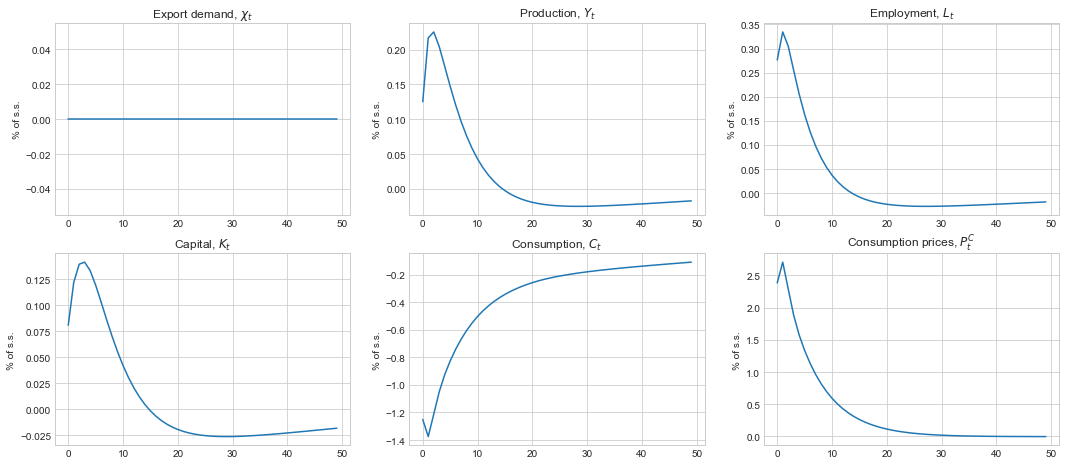

In [285]:
T_IRF = 50

fig = plt.figure(figsize=(3*6,3*6/1.5))

ax = fig.add_subplot(3,3,1)
ax.plot((sol.chi[:T_IRF]/ss.chi-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Export demand, $\chi_t$')

ax = fig.add_subplot(3,3,2)
ax.plot((sol.Y[:T_IRF]/ss.Y-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Production, $Y_t$')

ax = fig.add_subplot(3,3,3)
ax.plot((sol.L[:T_IRF]/ss.L-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Employment, $L_t$')

ax = fig.add_subplot(3,3,4)
ax.plot((sol.K[:T_IRF]/ss.K-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Capital, $K_t$')

ax = fig.add_subplot(3,3,5)
ax.plot((sol.C[:T_IRF]/ss.C-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Consumption, $C_t$')

ax = fig.add_subplot(3,3,6)
ax.plot(((sol.P_C[:T_IRF])/(ss.P_C)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Consumption prices, $P^C_t$');